


# Introduction to Factor models
---

**🎯 Learning Objectives**

By the end of this chapter, you should be able to:

1. **Decode the α / β decomposition.**  
   Learn how any asset’s excess return can be split into a factor‐driven piece (β × factor) and an asset-specific alpha, and see how this dual role lets factor models describe both risk and expected return.  

2. **Estimate factor exposure and alpha with regression.**  
   Use time-series regressions of excess returns on factor returns to obtain β, α, residuals, and the associated statistics that guide portfolio design.  

3. **Create tracking and hedged portfolios.**  
   Build a *tracking* portfolio equal to β times the factor, and a *hedged* (portable-alpha) portfolio that subtracts the tracking position—delivering pure alpha with zero in-sample factor risk.  

4. **Size positions under explicit risk budgets.**  
   Apply volatility budgets at daily, monthly, or annual horizons; compute how much capital you can allocate to an unhedged position versus a hedged one, given its variance components.  

5. **Appreciate the practical uses of factor models.**  
   Understand why asset managers, pod shops, and risk desks rely on factor models to separate skill from beta, impose discipline on risk taking, and communicate performance.



---







## Table of Contents


1. Towards a Factor Model
2. Risk Models vs Expected Returns Models
3. Alpha and Beta(s)
4. Tracking, Hedging, and Hedged Portfolios
5. Factor Models and Risk Budgets
6. Sharpe Ratio
7. Appraisal Ratio
8. Variance Decomposition
9. Key Takeaways

## Libraries and Auxiliary Functions

Libraries

- wrds: Connects to the Wharton Research Data Services (WRDS) database to access financial data.
= numpy: Provides support for large multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
- pandas: Provides data structures (like DataFrames) and tools for data analysis and manipulation.
- matplotlib.pyplot: A plotting library used for creating static, interactive, and animated visualizations in Python.
- pandas_datareader.data: Allows fetching financial data from various internet sources.
- datetime: Supplies classes for manipulating dates and times.

Functions

- get_daily_wrds: Using wrds get daily stock market returns. It takes as input the connection and the list of tickers you want

- get_factors: using the DataReader API it gets factors from Ken French website. If you don't pass aythign it returns the risk-free rate and the market. If you pass "FF6=True" it returns 5 addional factors that we will discuss later in the class

In [ ]:
## Every time we start a new colab we need to install and import WRDS (if we are goign to use it)
## The way it works is that you click install and then an error is returned and you click "RESTART"
## Once you do that you can import it (i.e. run the next cell)

#%pip install wrds

In [ ]:
## for this to work you first need to install it
#import wrds

In [ ]:
# load libraries

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import datetime

# define functions
def get_daily_wrds(conn,tickers=None):

    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    # Query daily stock file for the specified PERMNOs
    query = f"""
        SELECT permno, date, ret, retx, prc
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date,permno
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
# Pivot data to have dates as index and tickers as columns
    daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')
    daily_returns=daily_returns[tickers]

    return daily_returns



def get_factors(ff6=False):

    fama_french = DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench",start="1926-01-01")
    daily_data = fama_french[0]  # The first DataFrame contains the daily data
    daily_data.index = pd.to_datetime(daily_data.index)  # Ensure index is datetime
    if ff6==False:
        df_factor = daily_data[['RF','Mkt-RF']]  # Extract the Risk-Free Rate (RF)
    else:
        df_factor = daily_data[['RF','Mkt-RF','SMB','HML','RMW','CMA']]
        fama_french = DataReader("F-F_Momentum_Factor_daily", "famafrench",start="1926-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')

    return df_factor/100

## Towards a Factor Model
- First idea is that stocks might have different degree of co-movement
- For example, Defensive stocks like utilities, supermarkets, and so on might not suffer as much when the market tanks
    - Their cash flow might be more recession proof for example
    - While luxury good producers like LMVH might be more sensitive to the stock market given its consumer base
- Small stocks, stocks with high leverage and so one might particularly suffer during economic busts



$$(excess~return)=(intercept)+(stock~beta)*(factor~excess~return)+ (idio~risk)$$



In [ ]:
# uncomment to dowload the data directly from WRDS and FRED

##############################################################################
# conn = wrds.Connection()

# # get our stock returns

# df=get_daily_wrds(conn,tickers=['SPY','WMT','JPM'])

# # GET RISK FREE RATE
# start_date = datetime.datetime(1960, 1, 1)  # Start date (adjust as needed)
# end_date = datetime.datetime.now()          # End date
# df_rf = DataReader("DGS3MO", "fred", start_date, end_date)
# df_rf.reset_index(inplace=True)
# df_rf.columns = ["Date", "rf"]
# df_rf.rf=(df_rf.rf/100)/252  # convert to daily
# df_rf.set_index("Date", inplace=True)

# # merge with the risk-free rate
# df=df.merge(df_rf, left_index=True, right_index=True,how='left')
# #
# df_re=df.drop(columns='rf').sub(df['rf'],axis=0)
# df_re.to_csv('../../assets/data/FactorModels_data1.csv')
##############################################################################



df_re=pd.read_csv('https://raw.githubusercontent.com/amoreira2/UG54/refs/heads/main/assets/data/FactorModels_data1.csv')
df_re.date=pd.to_datetime(df_re.date)
df_re.set_index('date',inplace=True)
df_re

,SPY,WMT,JPM
date,,,
1969-03-05,NaN,NaN,NaN
1969-03-06,NaN,NaN,NaN
1969-03-07,NaN,NaN,NaN
1969-03-10,NaN,NaN,NaN
1969-03-11,NaN,NaN,NaN
...,...,...,...
2024-12-24,0.010940,0.025614,0.016269
2024-12-26,-0.000106,0.001014,0.003252
2024-12-27,-0.010698,-0.012349,-0.008273


>🤝⏱️ **Think and Code**
>
>1. How do we estimate this model?
>
>$$(excess~return)=(intercept)+(stock~beta)*(SPY~excess~return)+ (idio~risk)$$
>
>2. What should we plot against our factor excess returns to see if it "worked"?
>
>3. What do you expect to see?
>
>4. What does your estimation says about the relationship between the stock specific component and the factor excess return?
>       - Does this condition always hold?
>5. How do we construct the stock specific component using your estimation?

beta of asset WMT is 0.6737719432407151
beta of asset JPM is 1.3949175281636013
Correlation of SPY with residuals of WMT and JPM
SPY    1.757762e-16
dtype: float64
SPY   -0.517778
dtype: float64


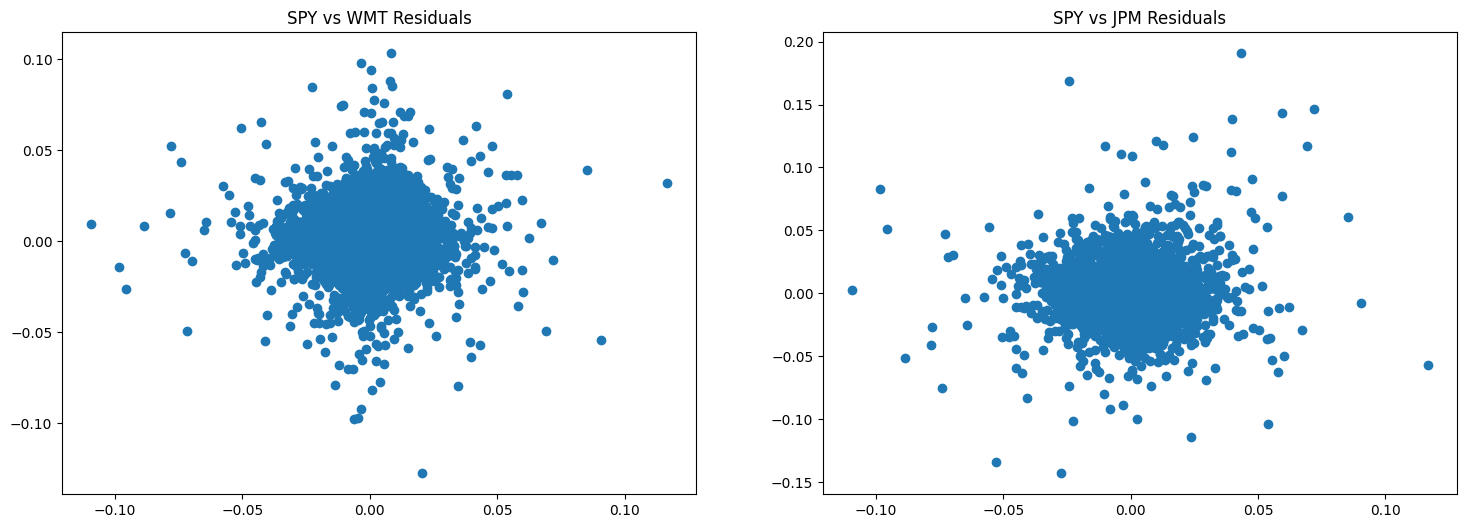

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(18,6))
import statsmodels.formula.api as smf
_temp= df_re.dropna(subset=['SPY', 'WMT'])


model = smf.ols(formula='WMT~SPY',data=_temp).fit()
intercept_wmt, beta_wmt = model.params
print(f'beta of asset WMT is {beta_wmt}')




axes[0].scatter(x=df_re['SPY'], y=(df_re['WMT']-beta_wmt*df_re['SPY']))
axes[0].set_title('SPY vs WMT Residuals')


model = smf.ols(formula='JPM~SPY',data=_temp).fit()
intercept_jpm, beta_jpm = model.params
print(f'beta of asset JPM is {beta_jpm}')




axes[1].scatter(x=df_re['SPY'], y=(df_re['JPM']-beta_jpm*df_re['SPY']))
axes[1].set_title('SPY vs JPM Residuals')


print('Correlation of SPY with residuals of WMT and JPM')
print(df_re[['SPY']].corrwith(df_re['JPM']-beta_jpm*df_re['SPY']))
print(df_re[['SPY']].corrwith(df_re['WMT']-beta_jpm*df_re['SPY']))

>🤝⏱️ **Think and Code**
>
> How do we estimate the amount of idiosyncratic risk?
>
> How do we estimate the amount of systematic risk?



##  Risk Models vs Expected Returns Models


1. 👉 **Risk** Models
- The risk $\epsilon$ is specific to asset $i$ and uncorrelated with other assets
- You don't really care whether the factors have premia, but only if they explain variation in returns
- It is essentially a model for the covariance matrix of returns
- Extremely used in the industry
- **(Q1) What it the key metric for whether a factor model is a good risk model?**

2. 👉**Expected Return** Models
 - The premium on the factor f, $E[f]$ summarize well the known "priced" systematic risk factors
 - By "priced" we mean risk-factors that earn a risk premium  $E[f]>0$ of $E[f]<0$
 - Because factors are long shorts we typically normalize so that the premium is positive
 - A model can be a good model of expected returns, but not explain much of realized returns
 - Such model is useful for performance evaluation
 - **(Q2)What is the key metric whether a factor model is a good expected return model?**



**A blurry distinction**

> We will call the first a factor model of risk, and the second a factor model of expected returns.
>
> However, this distinction is often blurry.
>
> Arbitrage logic tells us that if we have a really good model of risk, we should also have a good model of expected returns ( Who remembers this from Foundations? It is an a three letter acronym)
>
> But in practice for stocks, there is **lots and lots** of unexplained variation, so you explain a lot of return variation but still don't get a firm grip on expected returns

People start with a factor model with "priced" factors and then add additional factors to explain risk.

> what does "priced" means in this context? What are examples of priced factors and unpriced factors?



**More Precisely**

Let $r^e$         be an asset excess return over the risk-free rate

Let $f$    be a traded factor, for now  the **excess returns** on SPY ETF (that holds a basket that replicates the S&P 500 index)

Then we can write

$$r^e=\alpha + b*f+\epsilon$$

where $b$ is asset $i$ exposure to the factor $f$

> We can always write things that way--it is just a statistical decomposition

Whether we are working with a "Risk Model" or an "Expected Return" model will come down to the following

1. For risk model we assume $\epsilon$ uncorrelated across stocks
    👉 To explain risk , factors must capture all co-movement in REALIZED returns

    - (Q1) What does that mean in the context of the equation above?

1. For Expected return model, we assume $\alpha=0$ for all stocks/strategies
    👉 to explain risk premia, model needs to explain all variation in EXPECTED returns.

    - (Q2) What does that mean in the context of the equation above?

______________________________________________



## The organization of Wall Street: Alpha and Beta(s)

- the alpha/Beta decomposition is how the money management industry is organized.
    - Big bonuses only if people think you have **alpha**
    - Getting exposure to the factor is a commodity. Anyone can buy SPY or many other indexes that track the market very well
    - In many funds a portfolio manager mandate is to take no factor risk--or at least aim to be close to factor neutral.
  
         👉  specially true for portfolio managers working a pod shops
         -  [Citadel](https://www.wsj.com/finance/investing/citadel-ken-griffin-hedge-funds-c9ddf51d)
         -  [Millenium](https://www.wsj.com/finance/investing-the-giant-hedge-fund-that-hates-risk-and-still-wins-1110e90a)
         -  [Balyasny](https://www.bamfunds.com/)
    - In mutual funds it is still about the alpha--but the factor models are simpler (1 to 3 factors), so lots of factor exposure ends up counted as alpha when these factors have premia
   
- factor models allow you to understand and hedge risk
    - This is essential if you want to concentrate your portfolio only on risks that you get compensated for holding

## From Factor Exposure to Risk Premia

Note that

$$E[r]=E[rf+r^{e}]=rf+E[\alpha_i + b*f+\epsilon]$$

$$E[r]=rf+\alpha+b*E[f]+E[\epsilon]$$

- Using that $E[\epsilon]=0$ we have

$$E[r]=rf+\alpha+b*E[f]$$

- Thus, just like the risk of our asset could be attributed to the factor and it's component, the same model also allow us to decompose the expected return in terms of the risk-free rate, the premium coming from the common factor exposure $b*E[f]$ and the risk-premium specific to the asset, the ALPHA.


- The alpha does not need to be in a specific asset, can be in a combination of them

- The decomposition works the same for portfolio of assets

- For now we have a single factor, but you will see that as you have more factors, everything is exactly the same

- **⁉ If you have a good model of expected returns , what is the premia on your asset?**




## Focus on your skill, hedge all the residual risk
If you have an asset that has alpha, says, you are confident that Microsoft will beat expectations and you expect a 5% appreciation in the next 12 months beyond any factor exposure that Microsoft might had

**(Q3)  What should you do?**

Describe how would you implement this trade


**Implementing**

- Lets do this! I will use a regression to get some numbers for us to do this strategy

- **For now**, just think those as numbers as the truth

- **You should not think of the regression as giving the right numbers necessarily.** The regression gives use the best point estimate **in sample**

- What do we actuall want?




In [ ]:
# LOADING THE DATA

########################################################
# that is the code to get data from WRDS
# you need to have an account with WRDS and the wrds package installed
# uncomment the code below to get data from WRDS

# conn = wrds.Connection()
# ticker=['MSFT']
# df_returns = get_daily_wrds(conn,tickers=ticker)
# print(df_returns.head())
# df_returns.describe()
# I used this to save the data to a csv file and then load it from there
#df_returns.to_csv('../../assets/data/FactorModels_data2.csv')

df_returns=pd.read_csv('https://raw.githubusercontent.com/amoreira2/UG54/refs/heads/main/assets/data/FactorModels_data2.csv')
df_returns.date=pd.to_datetime(df_returns.date)
df_returns.set_index('date',inplace=True)
df_returns

,MSFT
date,
1986-03-13,NaN
1986-03-14,0.035714
1986-03-17,0.017241
1986-03-18,-0.025424
1986-03-19,-0.017391
...,...
2024-12-24,0.009374
2024-12-26,-0.002777
2024-12-27,-0.017302


In [ ]:
# this gets daily data on multiple factors plust the risk-free rate
# you can think of these factors as returns on funds that hold certain assets
# but the portfolios are constructed using a predefined rule
# for now we will use only the market factor and the risk-free rate

df_factor = get_factors()
# instead of merge them in the same dataframe. I will simply align then on the index
# I sometimes find more convenient to have them in separate dataframes
# but aligned on the same dates
df_returns, df_factor = df_returns.dropna().align(df_factor.dropna(), join='inner', axis=0)

display(df_factor.head())
display(df_returns.head())

/tmp/ipython-input-928730754.py:38: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench",start="1926-01-01")


,RF,Mkt-RF
1986-03-14,0.0003,0.0103
1986-03-17,0.0003,-0.0076
1986-03-18,0.0003,0.0047
1986-03-19,0.0003,-0.0017
1986-03-20,0.0003,0.0039


,MSFT
1986-03-14,0.035714
1986-03-17,0.017241
1986-03-18,-0.025424
1986-03-19,-0.017391
1986-03-20,-0.026549


In [ ]:
# RUNNING THE REGRESSION
##########################################################
df_eret=df_returns['MSFT']-df_factor['RF']
import statsmodels.api as sm

X = df_factor['Mkt-RF']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df_eret

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     6940.
Date:                Thu, 11 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:27:08   Log-Likelihood:                 26516.
No. Observations:                9778   AIC:                        -5.303e+04
Df Residuals:                    9776   BIC:                        -5.301e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.581      0.0

>🤝⏱️**Stop and Think**
>
>- Assuming this alpha is true. Is it large? Could you make a living out of this?


In [ ]:
# REGRESSION RESULTS

###########################################
alpha=model.params['const']
beta=model.params['Mkt-RF']
var_r=y.var()
var_f=df_factor['Mkt-RF'].var()
var_e=model.resid.var()
mu_f=df_factor['Mkt-RF'].mean()
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")
print(f"Variance of MSFT returns (var_r): {var_r}")
print(f"Variance of market factor (var_f): {var_f}")
print(f"Variance of residuals (var_e): {var_e}")
print(f"Mean of market factor (mu_f): {mu_f}")

# NOTE: An alternative way to get vizualize the results is simply use the summary mothod on the estiamted "model"
# this is not what we want here becasue we want to store the different coefficients in different variables to use them in out trading strategy

#model.summary()

Alpha: 0.0005823266697619099
Beta: 1.1873101041534255
Variance of MSFT returns (var_r): 0.00044165728317184484
Variance of market factor (var_f): 0.0001300756726848574
Variance of residuals (var_e): 0.0002582889201429655
Mean of market factor (mu_f): 0.0003594497852321538


## Tacking, Hedging and Hedged portfolios

**Tracking Portfolios**

We also refer to it as "hedging portfolios" or "mimicking portfolios"

Tracking portfolios are the portfolios that use a set of factors to track the returns on an asset.

* It can be used as a way to construct hedges for corporations, hedges for trading strategies, or a way to define a benchmark for an active manager

* It is used to construct what people in the industry calls "portable alpha", because it allows one to separate the alpha of a trading strategy's factor exposure

* The idea of the tracking portfolio is to track the component of an asset return that can be obtained by investing in a simple traded factor (or combos of traded factors). For now, this means the market portfolio.


* For a given factor model representation of a trading strategy

  $$r^e_i=\alpha_i+\beta_if+\epsilon_i, $$

  with $var(\epsilon_i)=\sigma_e^2$

* the asset $i$ Tracking portfolio is $\beta_i\times W^{MKT}$, where $W^{MKT}$ is the vector of weights of the market portfolio.

* or if one is trading directly on the total market portfolio as an asset, the tracking portfolio weight on the market portfolio asset is simply $\beta_i$ on the ETF that holds the market portfolio

>- In our case above we say the tracking portfolio of the stock is $\beta$ and the hedging portfolio -$\beta$ on the market



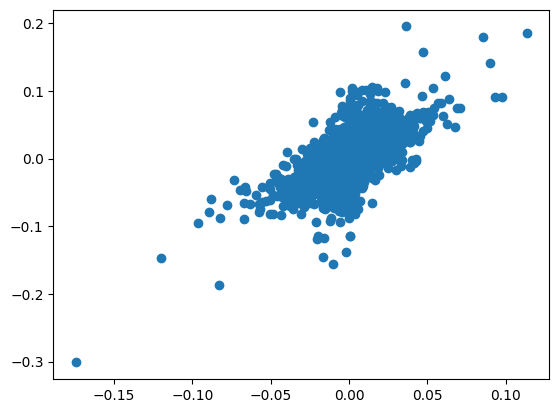

In [ ]:
# Returns on the the market and the asset

Portfolio=df_eret
MKT=df_factor['Mkt-RF']
Tracking=MKT*beta
plt.scatter(x=MKT,y=Portfolio)



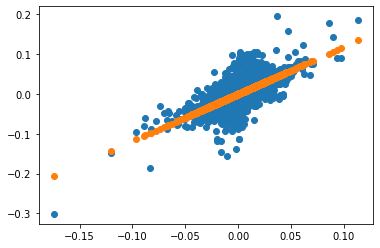

In [ ]:
# adding the tracking portfolio
plt.scatter(x=MKT,y=Portfolio)
plt.scatter(x=MKT,y=Tracking)
plt.legend(['Portfolio','Tracking'])


- We see  the obvious fact that we cannot track at all variation in the stock with the market portfolio

- they have some co-movement but also capture  different risks

- The tracking is a perfect straight line where the slope is the beta of the asset

**Hedged portfolio**

The Hedged strategy return (also called portable alpha) is

 $$r^{hedged}_i=r^e_i-\beta_ir^{MKT}$$

 * This portfolio can be constructed simply by $W^i-\beta^iW^{MKT}$, the weights of the trading strategy minus the tracking portfolio weights.
  
 * The excess returns take out risk-free rate effects
 * the hedged portfolio takes out market factor effects

👉 **Insight**

- The mean return of the hedged portfolio is just the time series alpha of the unhedged portfolio

    - Intuition: The hedged portfolio has mechanically zero beta (in-sample) so it's excess return is "pure" alpha

- The volatility of the strategy is the vol of the residuals of the time series regression

- If you run a regression on the market you will see that the hedged portfolios have $\beta=0$, which is by construction.

- This is the reason why sometimes people call these portfolios "Pure Alpha", or as Bridgewater calls it, "Portable Alpha"




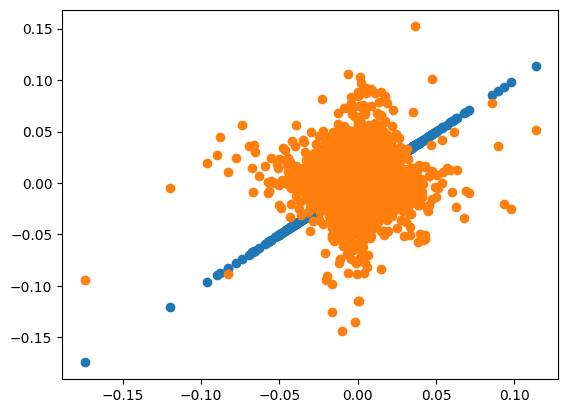

In [ ]:
# Returns on the hedged portfolio
Hedged=Portfolio-Tracking

plt.scatter(x=MKT,y=MKT)
plt.scatter(x=MKT,y=Hedged)
plt.show()



In [ ]:
# Verificaiton that they indeed the hedged portfolio harvest the alpha
print('hedge portfolio excess returns')
print(Hedged.mean()*12)
print('alpha of unhedge portfolio')
print(alpha*12)


hedge portfolio excess returns
0.006987920037142919
alpha of unhedge portfolio
0.006987920037142919


## Factor Models and Risk Budgets


### 🔧 Try it out

Lets say we have 1 million dollar per month volatility (i.e. standard deviation) budget

What that means? How much can I buy of MSFT?

What if the budget was for 1 year? How do I adjust my calculation?

Can I buy more or less?





### What is your **expected** PnL in the end of the year?

- Here we will subtract your funding costs, which I will assume is also rf so it will be a wash
- $rf+\beta*\mu_f+\alpha$ is your expected return
- $rf$ is your funding cost

Net of direct funding costs
$$x*(rf+\beta*\mu_f+\alpha-rf)*252$$


- Often shops have risk-adjusted PnL. So while you might expect to make ```x*(beta*mu_f+alpha)*252``` for the fund, they only comp you based on ```x*(alpha)*252```

Net of direct funding costs  and factor exposures
$$x*(rf+\beta*\mu_f+\alpha-rf-\beta*\mu_f)*252$$

- What is your risk-adjusted Expected PnL after your market exposure is subtracted

$$x*(\alpha)*252$$

In [ ]:
print(x*(beta*mu_f+alpha)*252)
print(x*(alpha)*252)



### Focusing on your edge

(Q4) Now suppose you focus your edge--i.e. investing in MSFT but hedging the market risk

1. How much of the market do I need to short per dollar invested in MSFT?


2. What your portfolio looks like?



3. How many dollars in MSFT can I buy? (lets say for a yearly budget)





### The benefits of focusing your bets




Note that the hedged portfolio return is

$$rh=re-\beta*f=\alpha+\epsilon$$

Note that $E[f\epsilon]=0$ as beta is such that there is no factor risk left in the residuals ( that is the OLS regression assumption!)

The leftover risk is exactly orthogonal to the factor risk

This what makes this the optimal hedge portfolio--> it hedges all the market risk!

So it follows that

$$Var(rh)=Var(\alpha+\epsilon)=Var(\epsilon)$$

- What is you expected  PnL?

- What is you expected "factor-adjusted PnL"?

In [ ]:
xe*(alpha*252)

## Sharpe Ratio

Sharpe ratio is one of the most important metrics in the industry

It measures how much extra return you are expected to earn per unit of risk

$$\frac{E[r]-rf}{\sigma(r)}$$


What is you portfolio Sharpe with the hedge and without the hedge?

Do you always come ahead by hedging it out?

## Appraisal Ratio


Appraisal ratio is the the most important metrics in the industry

It measures how much extra return you are expected to earn per unit of risk after your strip out all factor premia

$$\frac{E[r-bf-rf]}{\sigma(r-bf)}=\frac{\alpha}{\sigma(\epsilon)}$$


Often people with just call this the  Sharpe Ratio of the factor neutral portfolio, i.e. the Sharpe ratio of hedged portfolio

Do you always come ahead by hedging it out?

## Variance Decomposition

Factor models are essential to manage risk

A pod shop manager , a manager in a mutual fund in a large mutual fund company, a hedge fund trader in a large hedge fund,...all of those will typically have tight limits on the TOTAL risk of their portfolio, i.e. $var(r)$ but also on the factor component of their portfolio

But even if you don't, and you are an active manager with freedom of trading, you still want to control quite carefully which  risks you are taking in your portfolio

The decomposition here with single factor is really easy, but once you understand it, the multi-factor decomposition will be also easy to understand ( even it a little more involved)

1. The total variance of your strategy/asset is

$$Var(r^e)=Var(\alpha +b*f+\epsilon)=Var(b*f)+Var(\epsilon)=b^2Var(f)+var(\epsilon)$$

We can see already the factor part $(b^2Var(f))$ and the idiosyncratic part $var(\epsilon)$. It decomposes nicely because e and f are orthogonal.

2. The fraction of factor risk in your portfolio is

$$\frac{b^2Var(f)}{Var(r^e)}$$

You factor risk depends

- on your factor beta--this might grow in a market turmoil for example
- on the factor variance--also might grow when markets are choppy

The factor risk-share also depend on the idio vol. During a market turmoil all vols tend to go up, but factor vols tend to go up more

So both your total risk grows as the share of factor risk

In [ ]:
beta**2*var_f/var_r

0.4141025460425463

---
## 📝 Key Takeaways

- **Factor models separate what you *earn* from what you *ride*.**  
  Beta captures common market movements; alpha is the slice of return not explained by those movements.  

- **Hedging out β turns views into “portable” alpha.**  
  Going long the asset and short β units of the factor neutralizes systematic risk, leaving a position whose mean excess return equals its alpha and whose volatility equals the residual variance.  

- **Risk budgets shrink once you hedge intelligently.**  
  A hedged position’s lower volatility allows you to deploy more capital for the same risk cap—and to earn more alpha-attributed P&L.  

- **Variance decomposition is your monitoring dashboard.**  
  It tells you how much of today’s risk is coming from factors versus idiosyncratic shocks and highlights when market turmoil swells the factor share.  

- **Tracking portfolios clarify performance attribution.**  
  By explicitly matching the factor component, you can assess whether a manager’s outperformance is genuine skill or just hidden beta.  

- **Factor-implied covariance matrices are parsimonious and , maybe, more intuitive.**  
  Estimating only N betas, N idiosyncratic variances, and one factor variance yields a workable covariance estimate even when the full N × N matrix is unmanageable.  

- **All numbers are frequency-specific.**  
  Alpha, variances, co-variances and Sharpe ratios must be annualized (or otherwise scaled) consistently before comparison or budgeting.  Beta is the only one that is theoretically invariant



---


